In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
import vorpy as vp  # This takes ~20s for CUDA version to load


  Activating

Max number of thread: 640
Register usage: 96
Memory usage: (local = 280, shared = 0, constant = 0)


 project at `~/Dropbox/code/vorpy`


In [2]:
# from juliacall import Main as jl

# # Activate Julia environment in the
# # current working directory (which should be vorpy)
# jl.Pkg.activate('.')

# # Run the Julia script to load the Biot-Savart
# # function.
# jl.include('julia_src/weighted_biot_savart_kernel_cuda.jl')
# # User API
# def bs_solve_cuda(fps, vpps, vcrds, vcirs):
#     return np.transpose(jl.bs_solve_cuda(np.transpose(fps),
#                                         np.transpose(vpps), vcrds, vcirs))


# # Run the Julia script to load the Biot-Savart
# # function.
# jl.include('julia_src/weighted_biot_savart_kernel_cpu.jl')  # GPU version
# def bs_solve_cpu(fps, vpps, vcrds, vcirs):
#     return np.transpose(jl.bs_solve_cpu(np.transpose(fps),
#                                         np.transpose(vpps), vcrds, vcirs))

In [3]:
# # Check what directory Julia is workout out of
# jl.pwd()

In [4]:
# # Activate the Julia environment of the current
# # directory.
# # If Julia's working directory is
# # '/home/user1/Dropbox/code/vorpy',
# # then the following will work.
# jl.Pkg.activate('.')

In [5]:
# # Show the packages in the current Julia
# # environment. (This also helps to check
# # that we are using the right environment.)
# jl.Pkg.status()

In [6]:
# # Run the Julia script to load the Biot-Savart
# # function.

# jl.include('julia_src/weighted_biot_savart_kernel_cpu.jl')  # CPU version
# def bs_solve(fps, vpps, vcrds, vcirs):
#     return np.transpose(jl.bs_solve_cpu(fps.T, vpps.T, vcrds, vcirs))

# jl.include('julia_src/weighted_biot_savart_kernel_cuda.jl')  # GPU version
# # bs_solve = jl.bs_solve_cuda

In [9]:
###############################################
# Test the Biot-Savart function with a simple
# example.
# Consider a very long straight vortex line
# aligned with the x-axis. We will calculate
# the velocity at the origin and along the
# y-axis.
#
# ~2:30 min for 100 segments and 10e6 field
# points
# ~0:15 min for 100 segments and 1e6 field
# points
# Fewer segments but lots of field points
# is faster.
# Code scales like O(N) for field path
# segments (because we loop through each
# path segments).
###############################################

for i in range(10):
    print('Iteration: ', i)
    # Vortex line parameter
    NUMSEGS = 100
    # Field point parameter
    NUMFPS = 100  # At 100 CUDA is faster than CPU

    vpps = np.zeros((NUMSEGS+1, 3))
    vpps[:, 0] = np.linspace(-1000, 1000, NUMSEGS+1)
    vcrds = np.ones(NUMSEGS+1) * 2
    vcirs = np.ones(NUMSEGS) * 1

    fps = np.zeros((NUMFPS, 3))
    fps[:, 1] = np.random.default_rng().uniform(0, 20, NUMFPS) #np.linspace(0, 20, NUMFPS)
    fps[0, 1] = 1e-3
    # print('Field points: ', fps[:, 1])

    # vel_num = np.transpose(bs_solve(fps.T, vpps.T, vcrds, vcirs))
    # print('Shape of returned velocity array: ', np.shape(vel_num))

    t0 = time.time_ns()
    vel_num = vp.bs_solve(fps, vpps, vcrds, vcirs, device='cpu')
    # vel_num = bs_solve_cpu(fps, vpps, vcrds, vcirs)
    print('Time (CPU):\t', (time.time_ns() - t0) * 1e-9)

    # t0 = time.time_ns()
    # vel_num = vp.bs_solve(fps, vpps, vcrds, vcirs, device='cuda')
    # # vel_num = bs_solve_cuda(fps, vpps, vcrds, vcirs)
    # print('Time (CUDA):\t', (time.time_ns() - t0) * 1e-9)

    # # Plot the magnitude of the velocity
    # # along the y-axis
    # stride = slice(1, -1, 1)
    # plt.plot(fps[stride, 1], vel_num[stride, -1], 'x')
    # plt.xlabel('y')
    # plt.ylabel('vz')
    # plt.title('Velocity of a straight vortex line')
    # plt.show()


Iteration:  0
Time (CPU):	 1.9701840000000002
Iteration:  1
Time (CPU):	 0.050877000000000006
Iteration:  2
Time (CPU):	 0.037680000000000005
Iteration:  3
Time (CPU):	 0.030214
Iteration:  4
Time (CPU):	 0.031841
Iteration:  5
Time (CPU):	 0.032543
Iteration:  6
Time (CPU):	 0.031379000000000004
Iteration:  7
Time (CPU):	 0.031168
Iteration:  8
Time (CPU):	 0.031470000000000005
Iteration:  9
Time (CPU):	 0.031531


In [7]:
# Vortex line parameter
NUMSEGS = 100
# Field point parameter
NUMFPS = 1_000

vpps = np.zeros((NUMSEGS+1, 3))
vpps[:, 0] = np.linspace(-1000, 1000, NUMSEGS+1)
vcrds = np.ones(NUMSEGS+1) * 3
vcirs = np.ones(NUMSEGS) * 1

fps = np.zeros((NUMFPS, 3))
fps[:, 1] = np.linspace(0, 20, NUMFPS)
fps[0, 1] = 1e-3

In [8]:
vel_ana =  vcirs[0] * (1 - np.exp(-0.5 * fps[:, 1]**2 / vcrds[0]**2)) / (2 * np.pi * fps[:, 1]) 
print('Shape of analytical velocity array: ', np.shape(vel_ana))

Shape of analytical velocity array:  (1000,)


In [10]:
# def bs_solve(fps, vpps, vcrds, vcirs, device='cpu'):
#     if device == 'cpu':
#         return np.transpose(jl.bs_solve_cpu(fps.T, vpps.T, vcrds, vcirs))
#     elif device == 'cuda':
#         return np.transpose(jl.bs_solve_cuda(fps.T, vpps.T, vcrds, vcirs))
#     else:
#         raise ValueError('Invalid device: {}'.format(device))

# vel_num = bs_solve(fps, vpps, vcrds, vcirs, device='cpu')

# vel_num = np.transpose(bs_solve(fps.T, vpps.T, vcrds, vcirs))
vel_num = vp.bs_solve(fps, vpps, vcrds, vcirs, device='cuda')
# vel_num = vpcu.bs_solve(fps, vpps, vcrds, vcirs)

print('Shape of returned velocity array: ', np.shape(vel_num))

Shape of returned velocity array:  (1000, 3)


Mean squared error:  1.608154059152274e-09


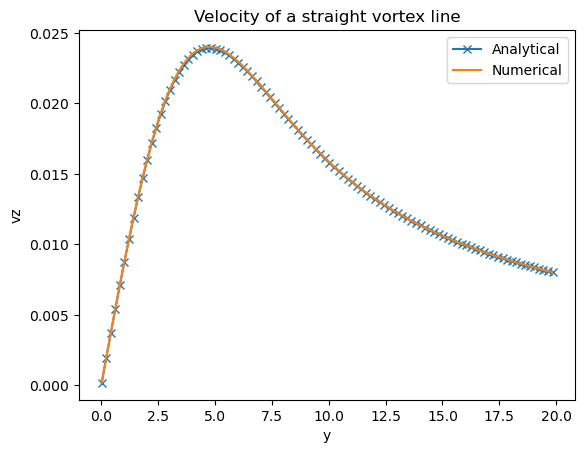

In [11]:
# Mean squared error
mse = np.mean((vel_ana - vel_num[:, -1])**2)
print('Mean squared error: ', mse)

# Plot the magnitude of the velocity
# along the y-axis

stride = slice(1, -1, 10)
plt.plot(fps[stride, 1], vel_ana[stride], 'x-')
plt.plot(fps[stride, 1], vel_num[stride, -1])
plt.xlabel('y')
plt.ylabel('vz')
plt.title('Velocity of a straight vortex line')
plt.legend(['Analytical', 'Numerical'])
plt.show()